Using cache found in C:\Users\Margarita/.cache\torch\hub\pytorch_vision_v0.9.0
C:\Users\Margarita\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Margarita\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/200 [00:00<?, ?it/s]

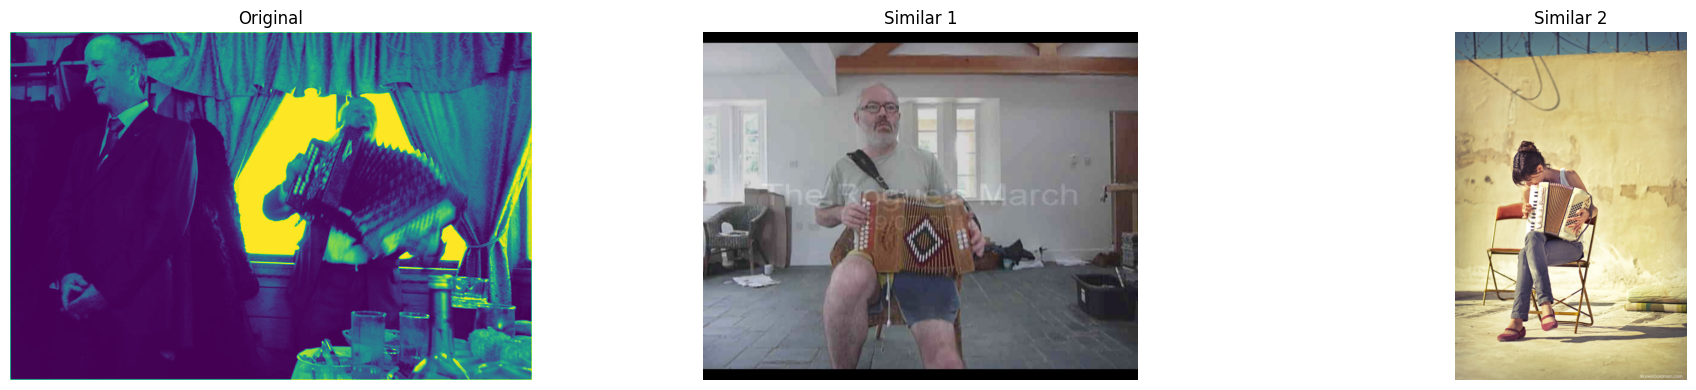

In [6]:
import os
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm

# Функция для загрузки и преобразования данных из локальной папки
def load_and_transform_local_images(image_folder, resize_to=None):
    images = []
    image_paths = []
    
    for filename in os.listdir(image_folder):
        file_path = os.path.join(image_folder, filename)
        try:
            img = Image.open(file_path)
            if img.mode != 'RGB':  # Преобразуем grayscale в RGB
                img = img.convert('RGB')
            if resize_to is not None:
                img = img.resize(resize_to)
            img = transforms.ToTensor()(img)
            images.append(img.numpy())
            image_paths.append(file_path)
        except Exception as e:
            print(f"Ошибка при обработке файла {file_path}: {e}")
    
    return images, image_paths

# Функция для извлечения признаков из изображений с использованием ResNet18
def extract_features_with_resnet18(images):
    model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
    model.eval()
    
    features = []
    with torch.no_grad():
        for img in tqdm(images):
            img_tensor = torch.from_numpy(img).unsqueeze(0)
            output = model(img_tensor)
            features.append(output.squeeze().numpy())
    
    return features

# Функция для создания DataFrame с индексами, именами файлов и признаками
def create_feature_dataset(features, image_paths):
    df = pd.DataFrame({
        'index': range(len(features)),
        'filename': [os.path.basename(path) for path in image_paths],
        'features': features
    })
    return df

# Функция для выполнения кластеризации
def perform_clustering(df, n_clusters=50):
    X = df['features'].to_list()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    df['cluster'] = kmeans.labels_
    return df

# Функция для поиска похожих изображений
def find_similar_images(df, query_index, top_n=5):
    query_row = df.iloc[query_index]
    query_filename = query_row['filename']
    query_cluster = query_row['cluster']
    
    same_cluster_df = df.query(f"cluster == {query_cluster} & filename != '{query_filename}'")
    
    similarities = {}
    for _, row in same_cluster_df.iterrows():
        similarity = cosine_similarity(
            query_row['features'].reshape(1, -1),
            row['features'].reshape(1, -1)
        )[0][0]
        similarities[row['filename']] = similarity
    
    sorted_filenames = sorted(similarities, key=lambda x: similarities[x], reverse=True)[:top_n]
    return sorted_filenames

# Функция для визуализации результатов
def visualize_results(df, filenames):
    fig, axes = plt.subplots(1, len(filenames) + 1, figsize=(20, 4))
    
    # Добавление оригинального изображения
    query_filename = df.iloc[query_index]['filename']
    query_filepath = next(path for path in image_paths if os.path.basename(path) == query_filename)
    original_img = Image.open(query_filepath)
    axes[0].imshow(original_img)
    axes[0].axis('off')
    axes[0].set_title("Original")
    
    # Отображение похожих изображений
    for i, filename in enumerate(filenames):
        filepath = next(path for path in image_paths if os.path.basename(path) == filename)
        similar_img = Image.open(filepath)
        axes[i + 1].imshow(similar_img)
        axes[i + 1].axis('off')
        axes[i + 1].set_title(f"Similar {i + 1}")
    
    plt.tight_layout()
    plt.show()

# Основная часть программы
if __name__ == "__main__":
    # Шаг 1: Загрузка и преобразование данных из локальной папки
    image_folder = '../Новая папка/Accordion'  # Укажите путь к вашей папке с изображениями
    resized_size = (224, 224)  # Размер изображений для ResNet18
    images, image_paths = load_and_transform_local_images(image_folder, resize_to=resized_size)
    
    # Шаг 2: Извлечение признаков из изображений
    features = extract_features_with_resnet18(images)
    
    # Шаг 3: Создание DataFrame с индексами, именами файлов и признаками
    feature_df = create_feature_dataset(features, image_paths)
    
    # Шаг 4: Выполнение кластеризации
    clustered_df = perform_clustering(feature_df)
    
    # Шаг 5: Выбор случайного изображения для поиска похожих
    query_index = np.random.randint(10, len(clustered_df))
    
    # Шаг 6: Поиск похожих изображений
    similar_filenames = find_similar_images(clustered_df, query_index, top_n=5)
    
    # Шаг 7: Визуализация результатов
    visualize_results(clustered_df, similar_filenames)

In [5]:
clustered_df.head(10)

,index,filename,features,cluster
0,0,001e9bee1924c738.jpg,"[-0.8755638, -1.2209654, -1.5800923, -0.169457...",30
1,1,0037a8ffc9230080.jpg,"[-1.2561319, -2.3908951, 1.6875864, 1.99225, -...",1
2,2,0073104477e43ea7.jpg,"[-3.4852395, -1.1757208, -2.7469268, -3.001329...",42
3,3,007576a0d87ce5d2.jpg,"[-4.493012, -3.7276454, 0.18989639, -0.0640349...",25
4,4,0089646f97a57599.jpg,"[-1.5731204, 1.5182343, -0.6882535, 1.3805506,...",20
5,5,00e50db1ace07231.jpg,"[-1.0498877, -2.5817904, 0.33124697, 1.556452,...",8
6,6,00eaaf3ecceb80a8.jpg,"[-3.088089, -0.309186, -0.970833, -0.2637396, ...",33
7,7,011598fe445e2077.jpg,"[1.1131188, -1.4331098, -1.3569301, -0.7955344...",34
8,8,0132311154629f26.jpg,"[-0.4864708, -0.7211681, 3.074679, 2.449836, 2...",42
9,9,01cc22eb34653a82.jpg,"[-1.1341137, 0.48521775, 0.88752496, 0.5536268...",32
